# Model evaluation

This notebook is a simple example of how to evaluate our model on our tet split of the NIST20 dataset.

We will show you how to perform **Simple evaluation**, **Comparison of more models' (including DB search) evaluations** and **Visualization of predictions**.

The stages are as follows:
1. Generate model predictions based on spectra 
2. Generate DB search predictions based on spectra and reference library
3. Evaluate the predictions
4. Compare the evaluated predictions
5. Visualize the predictions

## Generate model predictions

To generate model predictions we need to specify a configuration file and a path to the trained model. The configuration files are provided in the `config` directory as `predict_{libname}_{num_of_cands}.yaml`. 

The script [predict.py](../spectus/predict.py) is used to generate predictions. It takes the prepared `jsonl` file with spectra and outputs a `jsonl` file where each line is a `json` with keys being the generated SMILES strings and their values are candidates' probabilities generated by our model. We use these probabilities to sort candidates according to "the model's view".

Statistics and all metadata about the run are stored in `log_file.yaml` in the same directory as the predictions.

Running `predict.py` could look like this:

``` bash
CUDA_VISIBLE_DEVICES=0 python ../predict.py --checkpoint checkpoints/finetune/youthful-wave-590_exp5_9M_448+296/checkpoint-294952 \
                                            --output-folder predictions \
                                            --config-file configs/predict_nist.yaml
```

## Generate DB search predictions
To generate DB search predictions we need to specify output folder, a configuration file and a number of processors to use. The configuration files are provided in the `config` directory as `predict_db_search_{db_type}.yaml`. As reference library we use the NIST training set.

The script [predict_db_search.py](../spectus/predict_db_search.py) outputs a `jsonl` file where each line is a `json` with keys being the retrieved SMILES strings from DB and their values are spectra similarities. We use these similarities to sort candidates according to "the DB search's view". 

``` bash
python spectus/predict_db_search.py --output-folder predictions \
                                   --config-file configs/predict_db_search_${db_type}.yaml \
                                   --num-workers 32 &
```

## Evaluate predictions
Evaluation of predictions is done with the [evaluate_predictions.py](../spectus/evaluate_predictions.py) script. It takes a path to the predictions file, a path to the ground truth file and a path to a config file as input and appends all the evaluation metrics to the corresponding `log_file.yaml`. The script also generates several plots and saves them in the same directory as the predictions.

Running `evaluate_predictions.py` could look like this:

``` bash
python evaluate_predictions.py --predictions-path {path-to-predictions.jsonl} \
                               --labels-path data/nist/test.jsonl \
                               --config-file configs/evaluate_nist.yaml
```


## Compare the evaluated predictions
To compare the evaluated predictions we can use the [compare_models.py](../spectus/compare_models.py) script or [compare _models_interactive.ipynb](compare_models_interactive.ipynb) notebook. It takes a list of paths to the folder with models predictions and/or a list of paths to the folder with DB search predictions. The script generates a `*.txt` file comparing average top-k similarity, top-k accuracy, Win rate, ALAG and more.

A simple example of running `compare_models.py` could look like this:

```bash
python spectus/compare_models.py \
                --additional-info all_balmy_test \
                --models-prediction-paths \
                "./predictions/balmy-violet-577_exp5_224_148/NIST/1730720158_test_full_greedy \
                ./predictions/balmy-violet-577_exp5_224_148/NIST/1730754395_test_full_beam50 \
                ./predictions/balmy-violet-577_exp5_224_148/NIST/1730720159_test_full_beam10" \
                --db-search-prediction-paths \
                "./predictions/db_search_morgan_tanimoto/NIST/1731490929_test_full_1cand \
                ./predictions/db_search_sss/NIST/1731407440_test_full_50cand \
                ./predictions/db_search_sss/NIST/1731490929_test_full_1cand \
                ./predictions/db_search_sss/NIST/1731490894_test_full_10cand \
                ./predictions/db_search_hss/NIST/1731407440_test_full_50cand \
                ./predictions/db_search_hss/NIST/1731490929_test_full_1cand \
                ./predictions/db_search_hss/NIST/1731490894_test_full_10cand"
```

## Comment on the satistics' interpretation
The statistics are stored in the `log_file.yaml` in the same directory as the `predictions.jsonl`. Let's see what they mean:

`similsort` - predictions are sorted by the fingerprint similarity of the candidates to the query spectrum. It shows the upper bound on the model's performance when generating multiple candidates. This scenario can also mimic the situation with a domain expert that can pick the correct candiddate every time. It is the scenario described in our paper.

`probsort` - predictions are sorted by the model's probabilities. It shows the model's performance when generating multiple candidates without any other information on their quality.


### Example
```yaml
evaluation_0:
    average_num_of_predictions: '8.12'            # mean number of UNIQUE VALID candidates generated per query
    eval_config:                                  # log of configuration used for evaluation
        do_db_search: true
        filtering_args:
            max_mol_repr_len: 100
            max_mz: 500
            max_num_peaks: 300
            mol_repr: smiles
        fingerprint_type: morgan
        on_the_fly: true
        save_best_predictions: true
        fp_simil_function: tanimoto
        threshold: 0.85
    eval_time: 00:01:03
    formula_stats:                                   # statistics on molecular formulas      
        num_all_correct_formulas: 71272 / 229124     # from all generated candidates (num_queries x num_cands)
        num_at_least_one_correct_formula: '24315'    # at least one correct formula was generated for the query
        num_correct_formulas_at_best_prob: '19005'   # correct formula was returned as the best candidate (probsort)
        num_correct_formulas_at_best_simil: '21776'  # correct formula was returned as the best candidate (similsort)
        rate_of_all_correct_formulas: '0.31'        
        rate_of_at_least_one_correct_formula: '0.86'
        rate_of_correct_formulas_at_best_prob: '0.67'
        rate_of_correct_formulas_at_best_simil: '0.77'
    hit_at_k_prob: '[(1, 0.42), (2, 0.52), (3, 0.57),
        (4, 0.60), (5, 0.62), ...]'                 # percentage of correct formulas returned in top k 
                                                    # candidates (probsort) 
                                                    # note: this metric for similsort would not make sense
    molecular_weight_stats:
            mean_absolute_mw_difference_best_prob: '5.89'   # MW difference between label and the top
                                                                         # probsort candidate
            mean_absolute_mw_difference_best_simil: '6.18'  # MW difference between label and the top
                                                                         # similsort candidate
            mean_relative_mw_difference_best_prob: 2.14%                 # relative MW difference probsort
            mean_relative_mw_difference_best_simil: 2.17%                # relative MW difference similsort
            rate_of_exact_mw_prob: '0.66'
            rate_of_exact_mw_simil: '0.70'                 
            rate_of_mw_difference_less_than_1_best_prob: '0.73' # rate of MW difference less than 1 Da
            rate_of_mw_difference_less_than_1_best_simil: '0.74' # probsort and similsort
    labels_path: data/nist/test.jsonl
    num_datapoints_tested: '28267'
    num_empty_preds: '0'                            # number of queries with no valid candidates
    num_predictions_at_k_counter: '[28267, 28165, 27858, 27244, 26175, ...]' # number of queries with at least k 
                                                                             # valid candidates ([1, 2, 3, 4,...])
    precise_preds_stats:      # statistics on precise returned best candidates (exactly the same canonical SMILES)
        num_precise_preds_probsort: '11517'
        num_precise_preds_similsort: '18374'
        rate_of_precise_preds_probsort: '0.41'
        rate_of_precise_preds_similsort: '0.65'
    simil_1_hits:                              # statistics on returned best candidates with similarity 1
        counter_multiple_hits: dict_items([(1, 15623), (3, 1060), (2, 1341), (5, 91),...]) 
                            # monitors situations where more than one candidate has FP similarity equal to 1. 
                            # This can happen bcs of imperfection of FP similarity. 
                            # Format: (num of hits, num of occurences)
        num_1_hits_as_first_probsort: '11984'
        num_1_hits_as_first_similsort: '18476'
        num_fp_simil_fail_prob: '467'                    # number of queries where the best candidate 
        num_fp_simil_fail_simil: '102'                   # has similarity 1 but is not the correct one
        rate_of_1_hits_as_first_probsort: '0.42'
        rate_of_1_hits_as_first_similsort: '0.65'
    start_time_utc: 07/01/2025 13:50:00
    threshold_stats:            # statistics using a threshold (not backed by any theoretical
                                # or empirical reasoning, just to have a clue about "relatively good" candidates)
        num_better_than_threshold_probsort: '12292'
        num_better_than_threshold_similsort: '18658'
        rate_of_better_than_threshold_probsort: '0.43'
        rate_of_better_than_threshold_similsort: '0.66'
        threshold: '0.85'
    topk_probsort: '[0.67, 0.54, 0.49, 0.46,...]'     # mean similarities on k-th position (probsort) 
    topk_similsort: '[0.81, 0.60, 0.52, 0.46,...]'    # mean similarities on k-th position (similsort) 
```

## Visualize predictions
To see what the model's predictions look like we prepared a little visualization script.

In [3]:
import json
from pathlib import Path
from rdkit import Chem, DataStructs

from utils.eval_utils import load_labels_to_datapipe

# load labels and predictions
predictions_path = "../predictions/youthful-wave-590_exp5_9M_448+296/NIST/1736157156_test_full_beam10/predictions.jsonl" # CHANGE for the actual path
labels_path = "../data/nist/test.jsonl"


labels, _ = load_labels_to_datapipe(Path(labels_path))
labels = list(labels)
str_predictions = open(predictions_path).readlines()
dict_predictions = [json.loads(p) for p in str_predictions]
sorted_predictions = [sorted([k for k, _ in sorted(pred.items(), key=lambda x: x[1])]) for pred in dict_predictions]


/home/xhajek9/miniconda3/envs/trainSpectus/lib/python3.8/site-packages/torch/utils/data/datapipes/utils/common.py:137: UserWarning: Local function is not supported by pickle, please use regular python function or functools.partial instead.
  warnings.warn(



##################
GT smiles: COC(=O)c1ccccc1C(=O)Oc1ccc(C(C)C)cc1


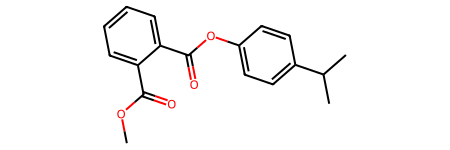

Prediction 0: COC(=O)c1ccccc1C(=O)Oc1c(C)cccc1C, similarity: 0.772972972972973


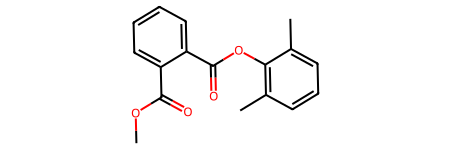

Prediction 1: COC(=O)c1ccccc1C(=O)Oc1cc(C)cc(C)c1, similarity: 0.8041431261770244


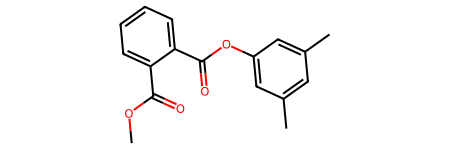

Prediction 2: COC(=O)c1ccccc1C(=O)Oc1ccc(C(C)C)cc1, similarity: 1.0


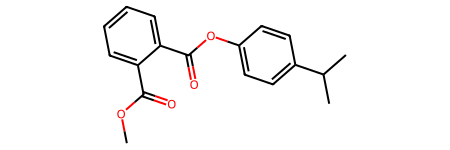

Prediction 3: COC(=O)c1ccccc1C(=O)Oc1ccc(C)c(C)c1, similarity: 0.8396946564885496


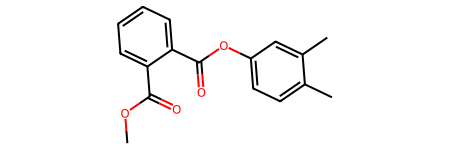

Prediction 4: COC(=O)c1ccccc1C(=O)Oc1ccc(C)cc1, similarity: 0.9166666666666666


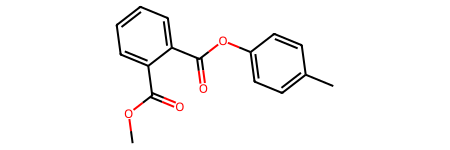

In [14]:
pairs_to_viz = list(zip(labels, sorted_predictions))[42]  # TODO: change this to visualize different pairs
best_n_to_viz = 5                                          # TODO: change this to visualize more/less predictions

if isinstance(pairs_to_viz, tuple):
    pairs_to_viz = [pairs_to_viz]

for gt_smiles, preds in pairs_to_viz:
    print("\n##################")
    print("GT smiles:", gt_smiles)
    gt_mol = Chem.MolFromSmiles(gt_smiles)
    display(gt_mol)
    for i, pred_smiles in enumerate(preds[:best_n_to_viz]):
        pred_mol = Chem.MolFromSmiles(pred_smiles)
        print(f"Prediction {i}: {pred_smiles}, similarity: {DataStructs.FingerprintSimilarity(Chem.RDKFingerprint(gt_mol), Chem.RDKFingerprint(pred_mol))}")
        display(pred_mol)